<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [PyData Integration](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/11.00-PyData-integration.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) |<p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/11.01-PyData-ddG-pssm.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Distributed analysis example: exhaustive ddG PSSM

## Notes
This tutorial will walk you through how to generate an exhaustive ddG PSSM in PyRosetta using the PyData stack for analysis and distributed computing.

This Jupyter notebook uses parallelization and is not meant to be executed within a Google Colab environment.

## Setup
Please see setup instructions in Chapter 15.00

## Citation
[Integration of the Rosetta Suite with the Python Software Stack via reproducible packaging and core programming interfaces for distributed simulation](https://doi.org/10.1002/pro.3721)

Alexander S. Ford, Brian D. Weitzner, Christopher D. Bahl

## Manual
Documentation for the `pyrosetta.distributed` namespace can be found here: https://nbviewer.jupyter.org/github/proteininnovation/Rosetta-PyData_Integration/blob/master/distributed_overview.ipynb

In [ ]:
import sys
if 'google.colab' in sys.modules:
   print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
   sys.exit(0)

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
import pandas
import seaborn
import matplotlib

In [3]:
import Bio.SeqUtils
import Bio.Data.IUPACData as IUPACData

In [4]:
import pyrosetta
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score

## Create test pose, initialize rosetta and pack

In [5]:
input_protocol = """
<ROSETTASCRIPTS>
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack" task_operations="only_pack" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""

In [6]:
input_relax = rosetta_scripts.SingleoutputRosettaScriptsTask(input_protocol)
# Syntax check via setup
input_relax.setup()

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /Users/jadolfbr/Library/Python/3.6/lib/python/site-packages/pyrosetta-2019.39+release.93456a567a8-py3.6-macosx-10.6-intel.egg/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python36.mac 2019.39+release.93456a567a8125cafdf7f8cb44400bc20b570d81 2019-09-26T14:24:44] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [8]:
raw_input_pose = score.ScorePoseTask()(io.pose_from_sequence("TESTESTEST"))
input_pose = input_relax(raw_input_pose)

## Perform exhaustive point mutation and pack

In [8]:
def mutate_residue(input_pose, res_index, new_aa, res_label = None):
    import pyrosetta.rosetta.core.pose as pose
    
    work_pose = packed_pose.to_pose(input_pose)
    
    # Annotate strucure with reslabel, for use in downstream protocol
    # Add parameters as score, for use in downstream analysis
    if res_label:
        work_pose.pdb_info().add_reslabel(res_index, res_label)
        pose.setPoseExtraScore(work_pose, "mutation_index", res_index)
        pose.setPoseExtraScore(work_pose, "mutation_aa", new_aa)
    
    if len(new_aa) == 1:
        new_aa = str.upper(Bio.SeqUtils.seq3(new_aa))
    assert new_aa in map(str.upper, IUPACData.protein_letters_3to1)
    
    protocol = """
<ROSETTASCRIPTS>
    <MOVERS>
        <MutateResidue name="mutate" new_res="%(new_aa)s" target="%(res_index)i" />
    </MOVERS>
    <PROTOCOLS>
        <Add mover_name="mutate"/>
    </PROTOCOLS>
</ROSETTASCRIPTS>
    """ % locals()
    
    return rosetta_scripts.SingleoutputRosettaScriptsTask(protocol)(work_pose)

In [9]:
refine = """
<ROSETTASCRIPTS>

  <RESIDUE_SELECTORS>
    <ResiduePDBInfoHasLabel name="mutation" property="mutation" />
    <Not name="not_neighbor">
      <Neighborhood selector="mutation" distance="12.0" />
    </Not>
  </RESIDUE_SELECTORS>
  
  <TASKOPERATIONS>
    <RestrictToRepacking name="only_pack"/>
    <OperateOnResidueSubset name="only_repack_neighbors" selector="not_neighbor" >
      <PreventRepackingRLT/>
    </OperateOnResidueSubset>
  </TASKOPERATIONS>

  <MOVERS>
    <PackRotamersMover name="pack_area" task_operations="only_pack,only_repack_neighbors" />
  </MOVERS>
  
  <PROTOCOLS>
    <Add mover="pack_area"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
    """
    
refine_mutation = rosetta_scripts.SingleoutputRosettaScriptsTask(refine)

# Mutation and pack

## Job distribution via `multiprocessing`

In [10]:
from multiprocessing import Pool
import itertools
with pyrosetta.distributed.utility.log.LoggingContext(logging.getLogger("rosetta"), level=logging.WARN):
    with Pool() as p:
        work = [
            (input_pose, i, aa, "mutation")
            for i, aa in itertools.product(range(1, len(packed_pose.to_pose(input_pose).residues) + 1), IUPACData.protein_letters)
        ]
        logging.info("mutating")
        mutations = p.starmap(mutate_residue, work)

INFO:root:mutating


## Job distribution via `dask`

In [11]:
import dask.distributed
cluster = dask.distributed.LocalCluster(n_workers=2, threads_per_worker=2)
client = dask.distributed.Client(cluster)

refinement_tasks = [client.submit(refine_mutation, mutant) for mutant in mutations]
logging.info("refining")
refinements = [task.result() for task in refinement_tasks]

client.close()
cluster.close()

INFO:root:refining


## Analysis of delta score

In [12]:
result_frame = pandas.DataFrame.from_records(packed_pose.to_dict(refinements))
result_frame["delta_total_score"] = result_frame["total_score"] - input_pose.scores["total_score"] 
result_frame["mutation_index"] = list(map(int, result_frame["mutation_index"]))

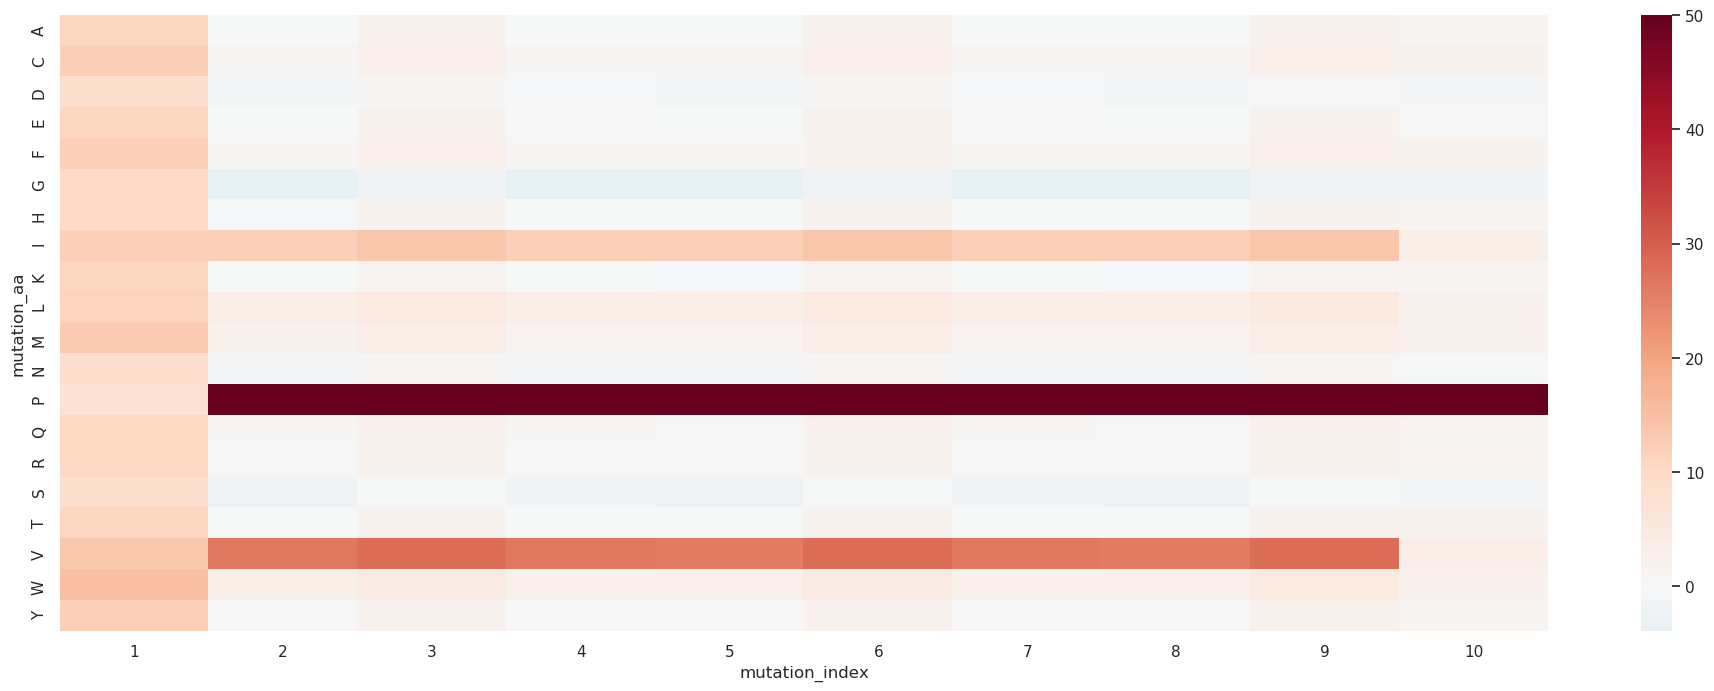

In [13]:
matplotlib.rcParams['figure.figsize'] = [24.0, 8.0]
seaborn.heatmap(
    result_frame.pivot("mutation_aa", "mutation_index", "delta_total_score"),
    cmap="RdBu_r", center=0, vmax=50)